In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm #最小二乘
from statsmodels.formula.api import ols #加载ols模型
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from scipy import log
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy.linalg as la
plt.rcParams['font.sans-serif'] = ['SimHei']   #设置简黑字体
plt.rcParams['axes.unicode_minus'] = False

B:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## 一、鲍鱼数据预处理 

In [5]:
#数据已经实现从R上面下载到本地
data = pd.read_csv("abalone.csv")

In [6]:
data=data.drop(columns=['Unnamed: 0'])

In [7]:
data.head(3)

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


### 1）对数据作图估计预测变量和被解释变量之间的函数关系 

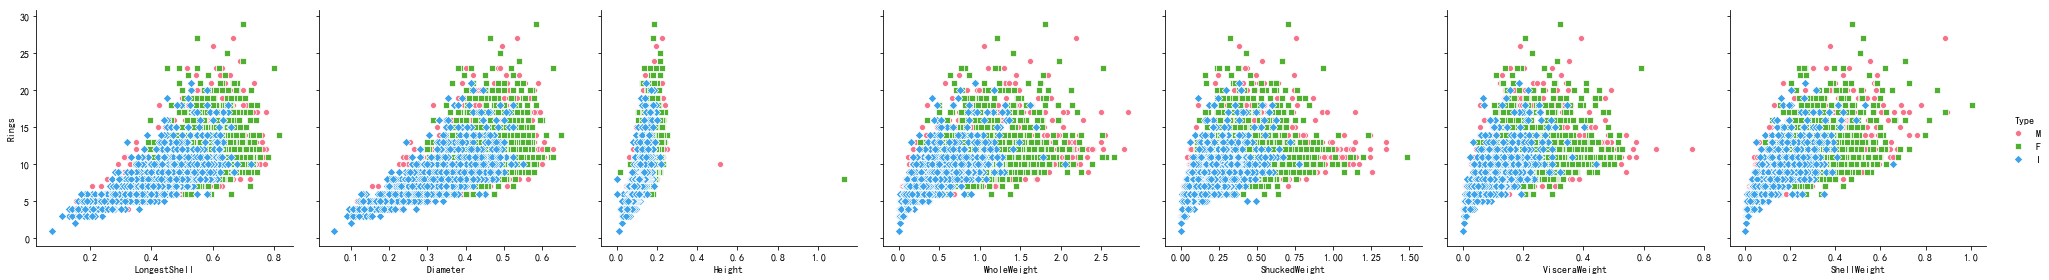

In [8]:
sns.pairplot(data, hue='Type',x_vars=data.columns[1:-1], y_vars='Rings', 
             markers=["o", "s", "D"],palette="husl",height=4)
#plt.title("图1-2 预测变量和被解释变量散点图(1)",fontsize=15,pad=-300,x=-0.5)


### 2）用散点图和相关系数图解释预测变量之间的相关性 

B:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


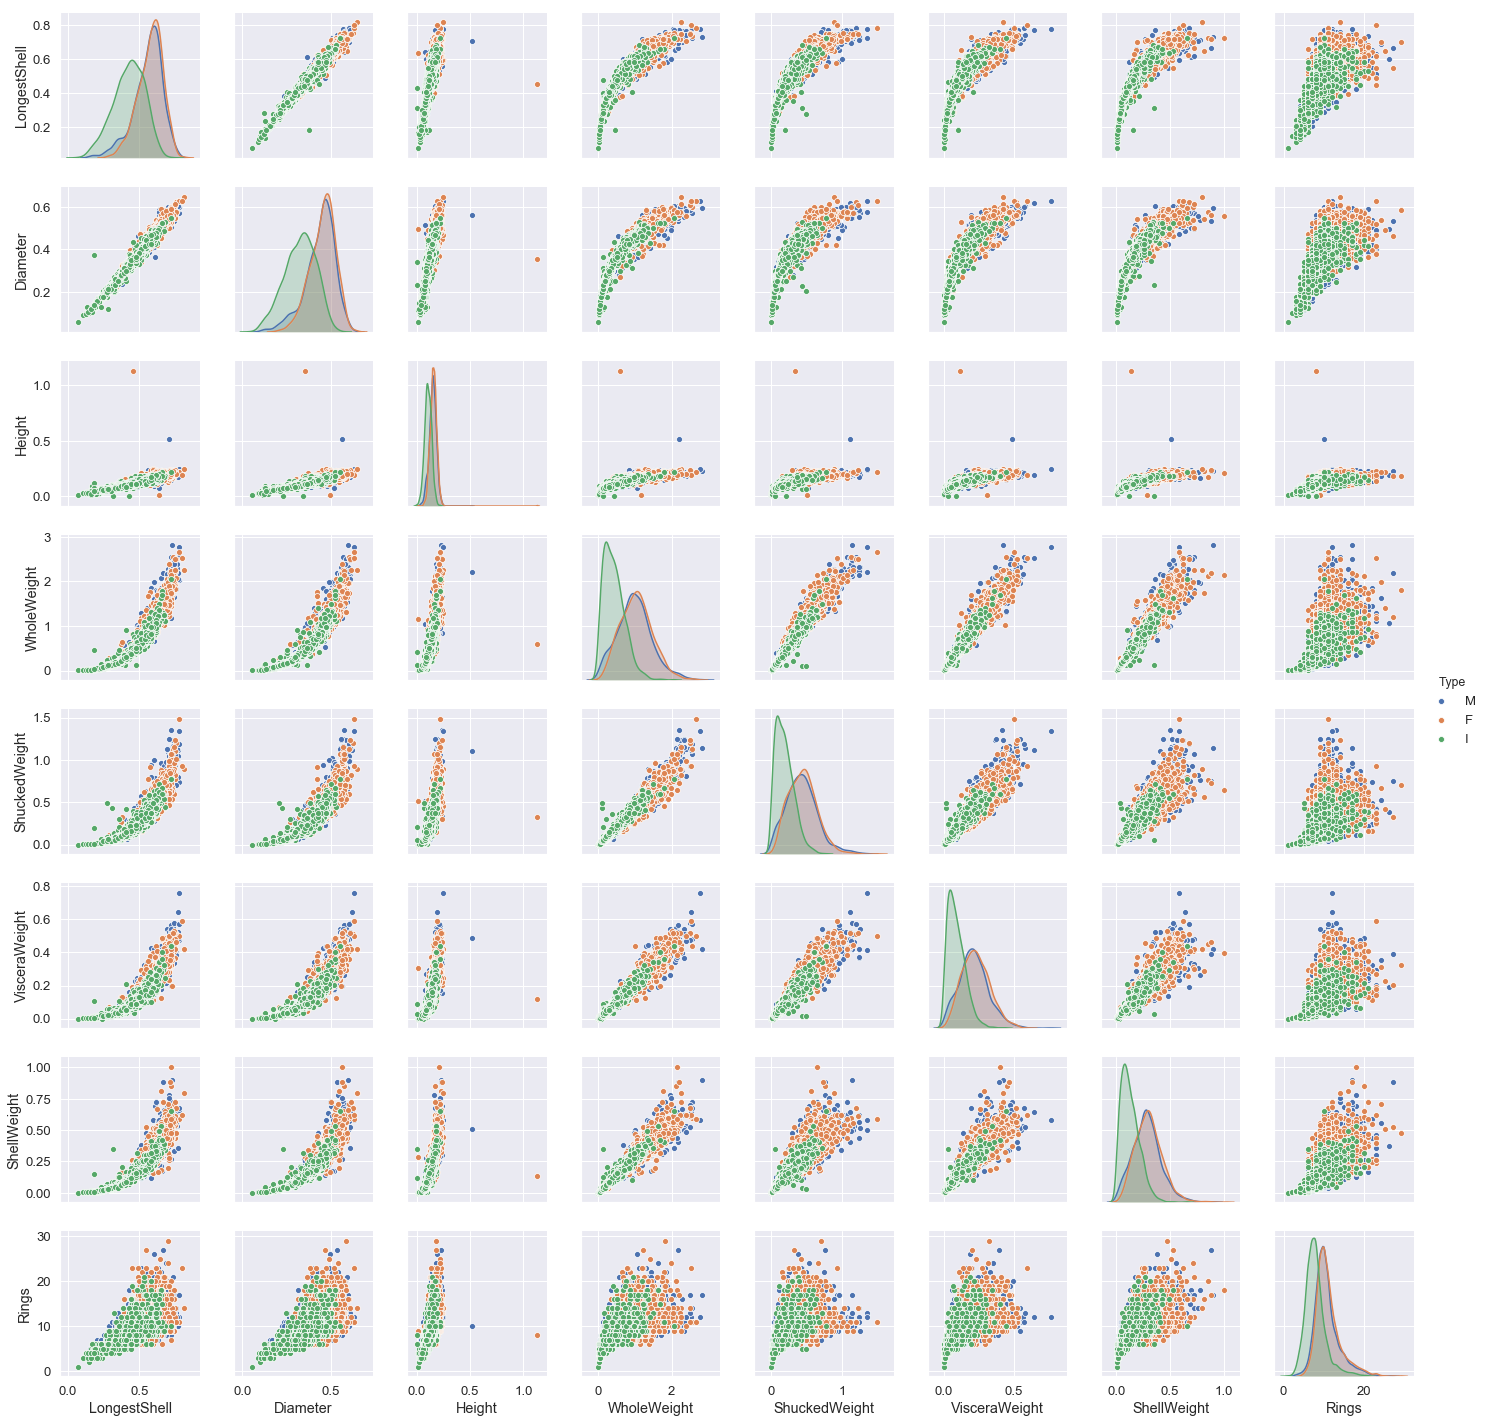

In [9]:
sns.set(font_scale=1.2)
sns.pairplot(data=data,hue='Type',vars=data.columns[1:])

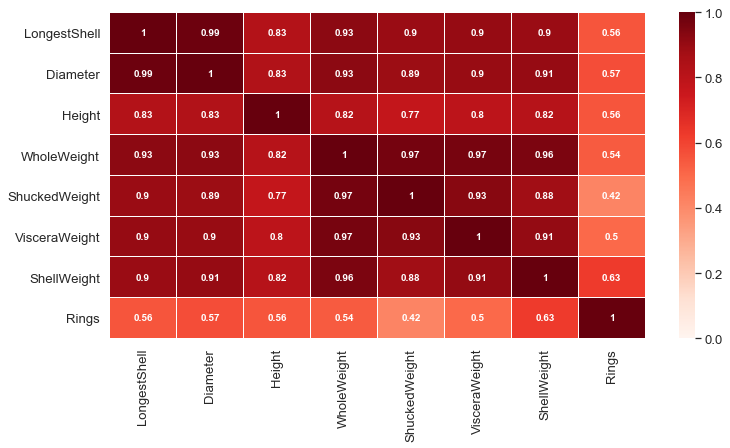

In [10]:
plt.figure(figsize=(12,6))
correlations = data.corr() 
correction=abs(correlations)# 取绝对值，只看相关程度 ，不关心正相关还是负相关
ax = sns.heatmap(correction,linewidths=0.05,cmap=plt.cm.Reds,vmax=1, vmin=0 ,annot=True,annot_kws={'size':10,'weight':'bold'})

### 3）对预测变量估计重要性得分。找到一种筛选方法得到预测变量子集，该集合不含冗余变量 

In [11]:
#X是连续变量数据 Y是被解释变量
X = data.iloc[:,1:-1]
Y=data.iloc[:,-1]

In [12]:
names = X.columns

In [13]:
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.5087, 'ShellWeight'), (0.1742, 'ShuckedWeight'), (0.09, 'WholeWeight'), (0.0717, 'VisceraWeight'), (0.0543, 'Height'), (0.052, 'Diameter'), (0.049, 'LongestShell')]


B:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 4）对连续型预测变量应用主成分分析，决定多少个不相关的主成分能够代表数据中的信息 

In [14]:
data.head(3)

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


In [15]:
#变量方差占比
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(data.iloc[:,1:-1])
pca.explained_variance_ratio_

array([9.74100729e-01, 1.14183886e-02, 8.37567021e-03, 3.03865180e-03,
       1.41047670e-03, 1.22936128e-03, 4.26722250e-04])

In [16]:
#前n个主成分的方差贡献率
for i in np.arange(1,8):
    print(sum(pca.explained_variance_ratio_[:i]))

0.974100729181708
0.9855191177581039
0.9938947879703453
0.9969334397713688
0.99834391646958
0.9995732777503926
1.0


## 二、模拟数据 

### 1）创建非线性函数 

In [17]:
def func(x1,x2,x3,x4,x5,e):
    return 10*math.sin(math.pi*x1*x2)+20*(x3-0.5)^2 +10*x4+5*x5+e

### 2) 随机模拟一个数据集，样本量是 500，绘制图形研究预测变量和被解释变量之间的关系 

In [18]:
#np.random.rand生成0~1之间的均匀分布数据，为区别变量在这基础上可给他们扩大倍数
x1=np.array(np.random.rand(500))
x2=np.array(np.random.rand(500))
x3=np.array(np.random.rand(500))
x4=np.array(np.random.rand(500))
x5=np.array(np.random.rand(500))
e=np.array( np.random.normal(loc=0,scale=0.2,size=500))

In [19]:
y=10*np.sin(math.pi*x1*x2)+20*(x3-0.5)**2 +10*x4+5*x5+e

In [43]:
df = pd.DataFrame((x1,x2,x3,x4,x5,e,y)).T

In [44]:
df.columns=['x1','x2','x3','x4','x5','e','y']

In [45]:
df.head(3)

,x1,x2,x3,x4,x5,e,y
0,0.307840,0.572695,0.678895,0.483410,0.409371,0.366042,13.146782
1,0.157551,0.814955,0.201945,0.198469,0.572284,0.320109,10.868170
2,0.460989,0.063883,0.469179,0.890536,0.365107,0.068940,11.742700


Text(0.5, 1.0, 'e')

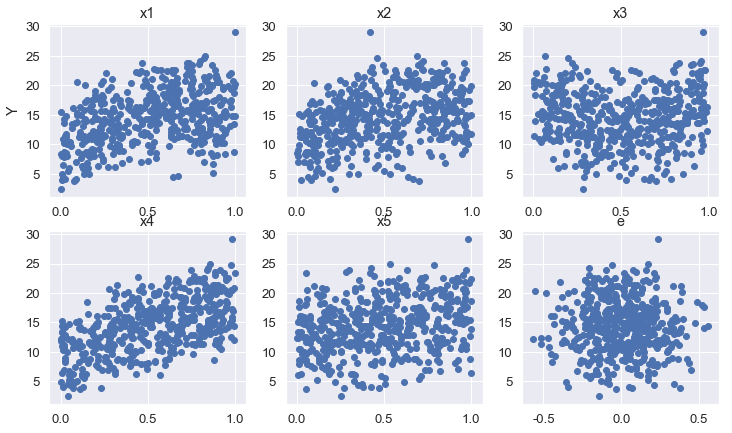

In [46]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.scatter(df.x1,y)
plt.title('x1')
plt.ylabel('Y')
plt.subplot(2,3,2)
plt.scatter(df.x2,y)
plt.title('x2')
plt.subplot(2,3,3)
plt.scatter(df.x3,y)
plt.title('x3')
plt.subplot(2,3,4)
plt.scatter(df.x4,y)
plt.title('x4')
plt.subplot(2,3,5)
plt.scatter(df.x5,y)
plt.title('x5')
plt.subplot(2,3,6)
plt.scatter(df.e,y)
plt.title('e')

### 3) 使用线性回归中的向前法、向后法和逐步回归等变量选择方法，最终模型选择了哪些变量？ 

In [47]:
#python线性回归函数那么多就没有一个能选回归计算方法的？？？
#定义向前逐步回归函数
def forward_select(data,target):
    variate=set(data.columns)  #将字段名转换成字典类型
    variate.remove(target)  #去掉因变量的字段名
    selected=[]
    current_score,best_new_score=float('inf'),float('inf')  #目前的分数和最好分数初始值都为无穷大（因为AIC越小越好）
    #循环筛选变量
    while variate:
        aic_with_variate=[]
        for candidate in variate:  #逐个遍历自变量
            formula="{}~{}".format(target,"+".join(selected+[candidate]))  #将自变量名连接起来
            aic=ols(formula=formula,data=data).fit().aic  #利用ols训练模型得出aic值
            aic_with_variate.append((aic,candidate))  #将第每一次的aic值放进空列表
        aic_with_variate.sort(reverse=True)  #降序排序aic值
        best_new_score,best_candidate=aic_with_variate.pop()  #最好的aic值等于删除列表的最后一个值，以及最好的自变量等于列表最后一个自变量
        if current_score>best_new_score:  #如果目前的aic值大于最好的aic值
            variate.remove(best_candidate)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            selected.append(best_candidate)  #将此自变量作为加进模型中的自变量
            current_score=best_new_score  #最新的分数等于最好的分数
            print("aic is {},continuing!".format(current_score))  #输出最小的aic值
        else:
            print("for selection over!")
            break
    formula="{}~{}".format(target,"+".join(selected))  #最终的模型式子
    print("final formula is {}".format(formula))
    model=ols(formula=formula,data=data).fit()
    return(model)

In [48]:
forward_select(data=df,target="y")

aic is 2747.8307100650595,continuing!
aic is 2619.9387275268505,continuing!
aic is 2426.6173604594346,continuing!
aic is 2263.5641827623667,continuing!
for selection over!
final formula is y~x4+x2+x1+x5


### 4) 应用不同的过滤法，逐个评估变量。一些过滤法同时评估多个变量（如ReliefF 算法），两个有交互效应的预测变量 x 1 和 x 2 否被选中了？是否倾向于选择其中某一个变量？ 

In [49]:
df.head()

,x1,x2,x3,x4,x5,e,y
0,0.307840,0.572695,0.678895,0.483410,0.409371,0.366042,13.146782
1,0.157551,0.814955,0.201945,0.198469,0.572284,0.320109,10.868170
2,0.460989,0.063883,0.469179,0.890536,0.365107,0.068940,11.742700
3,0.999546,0.736992,0.977812,0.565979,0.525177,0.072213,20.285152
4,0.951365,0.389013,0.453903,0.366083,0.431640,0.037258,15.077492


In [50]:
df.y.describe()

count    500.000000
mean      14.470045
std        4.594994
min        2.477492
25%       11.321582
50%       14.434855
75%       17.526184
max       29.103156
Name: y, dtype: float64

In [51]:
bins=[2,8,15,21,28]

In [52]:
# 数据离散化
group = pd.cut(df.y,right=True,retbins=False,bins=bins,include_lowest=False)
df1=df['y_gr'] = group

In [53]:
df1=df.drop(columns=['y'])

In [54]:
df1.head(3)

,x1,x2,x3,x4,x5,e,y_gr
0,0.307840,0.572695,0.678895,0.483410,0.409371,0.366042,"(8, 15]"
1,0.157551,0.814955,0.201945,0.198469,0.572284,0.320109,"(8, 15]"
2,0.460989,0.063883,0.469179,0.890536,0.365107,0.068940,"(8, 15]"


In [ ]:
class Relief:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: k近邻的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))
        self.__t = t
        self.__k = k

    # 数据处理（将离散型数据处理成连续型数据，比如字符到数值）
    def get_data(self):
        new_data = pd.DataFrame()
        for one in self.__feature[:-1]:
            col = self.__data[one]
            if (str(list(col)[0]).split(".")[0]).isdigit() or str(list(col)[0]).isdigit() or (str(list(col)[0]).split('-')[-1]).split(".")[-1].isdigit():
                new_data[one] = self.__data[one]
                # print '%s 是数值型' % one
            else:
                # print '%s 是离散型' % one
                keys = list(set(list(col)))
                values = list(xrange(len(keys)))
                new = dict(zip(keys, values))
                new_data[one] = self.__data[one].map(new)
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]
        return new_data

    # 返回一个样本的k个猜中近邻和其他类的k个猜错近邻
    def get_neighbors(self, row):
        df = self.get_data()
        row_type = row[df.columns[-1]]
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])
        aim = row.drop(df.columns[-1])
        f = lambda x: eulidSim(np.mat(x), np.mat(aim))
        right_sim = right_df.apply(f, axis=1)
        right_sim_two = right_sim.drop(right_sim.idxmin())
        right = dict()
        right[row_type] = list(right_sim_two.sort_values().index[0:self.__k])
        #print list(right_sim_two.sort_values().index[0:self.__k])
        types = list(set(df[df.columns[-1]]) - set([row_type]))
        wrong = dict()
        for one in types:
            wrong_df = df[df[df.columns[-1]] == one].drop(columns=[df.columns[-1]])
            wrong_sim = wrong_df.apply(f, axis=1)
            #wrong[one] = wrong_sim.sort_values().index[0:self.__k]
        print (right, wrong)
        return right, wrong

    # 计算特征权重
    def get_weight(self, feature, index, NearHit, NearMiss):
        # data = self.__data.drop(self.__feature[-1], axis=1)
        data = self.__data
        row = data.iloc[index]
        right = 0
        for one in list(NearHit.values())[0]:
            nearhit = data.iloc[one]
            if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                max_feature = data[feature].max()
                min_feature = data[feature].min()
                right_one = pow(round(abs(row[feature] - nearhit[feature]) / (max_feature - min_feature), 2), 2)
            else:
                right_one = 0 if row[feature] == nearhit[feature] else 1
            right += right_one
        right_w = round(right / self.__k, 2)

        wrong_w = 0
        # 样本row所在的种类占样本集的比例
        p_row = round(float(list(data[data.columns[-1]]).count(row[data.columns[-1]])) / len(data), 2)
        for one in NearMiss.keys():
            # 种类one在样本集中所占的比例
            p_one = round(float(list(data[data.columns[-1]]).count(one)) / len(data), 2)
            wrong_one = 0
            for i in NearMiss[one]:
                nearmiss = data.iloc[i]
                if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                    max_feature = data[feature].max()
                    min_feature = data[feature].min()
                    wrong_one_one = pow(round(abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature), 2), 2)
                else:
                    wrong_one_one = 0 if row[feature] == nearmiss[feature] else 1
                wrong_one += wrong_one_one

            wrong = round(p_one / (1 - p_row) * wrong_one / self.__k, 2)
            wrong_w += wrong
        w = wrong_w - right_w
        return w

    # 过滤式特征选择
    def reliefF(self):
        sample = self.get_data()
        # print sample
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)
        #print ('采样样本索引为 %s ' % sample_index)
        num = 1
        for i in sample_index:    # 采样次数
            one_score = dict()
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print ('第 %s 次采样，样本index为 %s，其NearHit k近邻行索引为 %s ，NearMiss k近邻行索引为 %s' % (num, i, NearHit, NearMiss))
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print ('特征 %s 的权重为 %s.' % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)
        print ('采样各样本特征权重如下：')
        print (f_w)
        print ('平均特征权重如下：')
        print (f_w.mean())
        return f_w.mean()

    # 返回最终选取的特征
    def get_final(self):
        f_w = pd.DataFrame(self.reliefF(), columns=['weight'])
        final_feature_t = f_w[f_w['weight'] > self.__t]
        print (final_feature_t)
        # final_feature_k = f_w.sort_values('weight').head(self.__k)
        # print final_feature_k
        return final_feature_t


# 几种距离求解
def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


def cosSim(vecA, vecB):
    """
    :param vecA: 行向量
    :param vecB: 行向量
    :return: 返回余弦相似度（范围在0-1之间）
    """
    num = float(vecA * vecB.T)
    denom = la.norm(vecA) * la.norm(vecB)
    cosSim = 0.5 + 0.5 * (num / denom)
    return cosSim


def pearsSim(vecA, vecB):
    if len(vecA) < 3:
        return 1.0
    else:
        return 0.5 + 0.5 * np.corrcoef(vecA, vecB, rowvar=0)[0][1]


if __name__ == '__main__':
    data = df1
    #print (data)
    f = Relief(data, 1, 0.2, 2)
    # df = f.get_data()
    # print type(df.iloc[0])
    # f.get_neighbors(df.iloc[0])
    # f.get_weight('色泽', 6, 7, 8)
    f.reliefF()
    # f.get_final()


{Interval(2, 8, closed='right'): [173, 11]} {}
第 1 次采样，样本index为 211，其NearHit k近邻行索引为 {Interval(2, 8, closed='right'): [173, 11]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.01.
特征 x2 的权重为 -0.03.
特征 x3 的权重为 0.0.
特征 x4 的权重为 -0.03.
特征 x5 的权重为 -0.01.
特征 e 的权重为 -0.01.
{Interval(15, 21, closed='right'): [411, 267]} {}
第 2 次采样，样本index为 188，其NearHit k近邻行索引为 {Interval(15, 21, closed='right'): [411, 267]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.02.
特征 x2 的权重为 -0.01.
特征 x3 的权重为 -0.01.
特征 x4 的权重为 0.0.
特征 x5 的权重为 -0.02.
特征 e 的权重为 0.0.
{Interval(8, 15, closed='right'): [194, 453]} {}
第 3 次采样，样本index为 38，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [194, 453]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 0.0.
特征 x2 的权重为 0.0.
特征 x3 的权重为 -0.03.
特征 x4 的权重为 -0.02.
特征 x5 的权重为 -0.01.
特征 e 的权重为 0.0.
{Interval(8, 15, closed='right'): [380, 100]} {}
第 4 次采样，样本index为 381，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [380, 100]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 0.0.
特征 x2 的权重为 -0.03.
特征 x3 的权重为 -0.03.
特征 x4 的权重为 -0.01.
特征 x5 的权

{Interval(8, 15, closed='right'): [22, 38]} {}
第 34 次采样，样本index为 57，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [22, 38]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 0.0.
特征 x2 的权重为 -0.01.
特征 x3 的权重为 0.0.
特征 x4 的权重为 -0.05.
特征 x5 的权重为 -0.01.
特征 e 的权重为 -0.01.
{Interval(8, 15, closed='right'): [459, 261]} {}
第 35 次采样，样本index为 297，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [459, 261]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.01.
特征 x2 的权重为 0.0.
特征 x3 的权重为 -0.01.
特征 x4 的权重为 -0.04.
特征 x5 的权重为 0.0.
特征 e 的权重为 0.0.
{Interval(8, 15, closed='right'): [102, 368]} {}
第 36 次采样，样本index为 270，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [102, 368]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.01.
特征 x2 的权重为 0.0.
特征 x3 的权重为 -0.02.
特征 x4 的权重为 -0.02.
特征 x5 的权重为 -0.03.
特征 e 的权重为 0.0.
{Interval(8, 15, closed='right'): [454, 103]} {}
第 37 次采样，样本index为 143，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [454, 103]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.02.
特征 x2 的权重为 -0.02.
特征 x3 的权重为 0.0.
特征 x4 的权重为 -0.03.
特征 x5 的权

{Interval(15, 21, closed='right'): [185, 83]} {}
第 67 次采样，样本index为 456，其NearHit k近邻行索引为 {Interval(15, 21, closed='right'): [185, 83]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.01.
特征 x2 的权重为 -0.01.
特征 x3 的权重为 -0.02.
特征 x4 的权重为 -0.01.
特征 x5 的权重为 -0.03.
特征 e 的权重为 -0.02.
{Interval(8, 15, closed='right'): [91, 454]} {}
第 68 次采样，样本index为 175，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [91, 454]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.01.
特征 x2 的权重为 -0.04.
特征 x3 的权重为 0.0.
特征 x4 的权重为 0.0.
特征 x5 的权重为 -0.01.
特征 e 的权重为 -0.01.
{Interval(8, 15, closed='right'): [372, 339]} {}
第 69 次采样，样本index为 166，其NearHit k近邻行索引为 {Interval(8, 15, closed='right'): [372, 339]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 0.0.
特征 x2 的权重为 -0.03.
特征 x3 的权重为 -0.02.
特征 x4 的权重为 -0.01.
特征 x5 的权重为 -0.03.
特征 e 的权重为 -0.01.
{Interval(15, 21, closed='right'): [47, 398]} {}
第 70 次采样，样本index为 105，其NearHit k近邻行索引为 {Interval(15, 21, closed='right'): [47, 398]} ，NearMiss k近邻行索引为 {}
特征 x1 的权重为 -0.04.
特征 x2 的权重为 -0.01.
特征 x3 的权重为 0.0.
特征 x4 的权重为 -0.0

In [56]:
df.iloc[:,-2]

0      13.146782
1      10.868170
2      11.742700
3      20.285152
4      15.077492
         ...    
495     3.770006
496     3.932564
497     9.915342
498    10.386852
499    12.137210
Name: y, Length: 500, dtype: float64

In [57]:
#02 相关系数
for i in range(6):
    print(pearsonr(df.iloc[:,i],df.iloc[:,-2]))

(0.394256183657745, 4.830491640423545e-20)
(0.35575116381691274, 2.308517701819414e-16)
(0.03933243236802455, 0.3801400447391706)
(0.5730948838145765, 5.465196816509742e-45)
(0.26106158968818266, 3.1045277331668637e-09)
(-0.009194103420784357, 0.8375126074529585)


In [61]:
df

,x1,x2,x3,x4,x5,e,y,y_gr
0,0.307840,0.572695,0.678895,0.483410,0.409371,0.366042,13.146782,"(8, 15]"
1,0.157551,0.814955,0.201945,0.198469,0.572284,0.320109,10.868170,"(8, 15]"
2,0.460989,0.063883,0.469179,0.890536,0.365107,0.068940,11.742700,"(8, 15]"
3,0.999546,0.736992,0.977812,0.565979,0.525177,0.072213,20.285152,"(15, 21]"
4,0.951365,0.389013,0.453903,0.366083,0.431640,0.037258,15.077492,"(15, 21]"
...,...,...,...,...,...,...,...,...
495,0.074399,0.701012,0.698356,0.111581,0.053953,-0.033623,3.770006,"(2, 8]"
496,0.006787,0.026369,0.659437,0.068802,0.469788,0.381581,3.932564,"(2, 8]"
497,0.500534,0.119879,0.308063,0.627890,0.175476,0.148344,9.915342,"(8, 15]"
498,0.820407,0.464561,0.628972,0.015212,0.152076,-0.169087,10.386852,"(8, 15]"


In [62]:
#03 线性模型 
lr = LinearRegression()
lr.fit(df.iloc[:,:-2], df.iloc[:,-2])

#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = list(df.iloc[:,:-2].columns), sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

print ("Linear model:", pretty_print_linear(lr.coef_))


Linear model: 6.404 * x1 + 6.735 * x2 + 0.123 * x3 + 9.895 * x4 + 5.041 * x5 + 0.111 * e


In [63]:
#04  L1正则化/Lasso
lasso = Lasso(alpha=.3)
lasso.fit(df.iloc[:,:-2], df.iloc[:,-2])
print ("Lasso model: ", pretty_print_linear(lasso.coef_, names = list(df.iloc[:,:-1].columns), sort = True))

Lasso model:  5.736 * x4 + 2.738 * x1 + 2.566 * x2 + 1.024 * x5 + 0.0 * x3 + -0.0 * e


In [64]:
#05 随机森林-平均不纯度减少
rf = RandomForestRegressor()
rf.fit(df.iloc[:,:-2], df.iloc[:,-2])
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), list(df.iloc[:,:-1].columns)), 
             reverse=True))


Features sorted by their score:
[(0.3889, 'x4'), (0.2264, 'x1'), (0.206, 'x2'), (0.0997, 'x5'), (0.0562, 'x3'), (0.0228, 'e')]


B:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
